In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
import math
sys.path.append("..")
from basic_tools import *
print(torch.cuda.is_available())

True


In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [3]:
def get_freq_indices(method):
    assert method in ['top1','top2','top4','top8','top16','top32',
                      'bot1','bot2','bot4','bot8','bot16','bot32',
                      'low1','low2','low4','low8','low16','low32']
    num_freq = int(method[3:])
    if 'top' in method:
        all_top_indices_x = [0,0,6,0,0,1,1,4,5,1,3,0,0,0,3,2,4,6,3,5,5,2,6,5,5,3,3,4,2,2,6,1]
        all_top_indices_y = [0,1,0,5,2,0,2,0,0,6,0,4,6,3,5,2,6,3,3,3,5,1,1,2,4,2,1,1,3,0,5,3]
        mapper_x = all_top_indices_x[:num_freq]
        mapper_y = all_top_indices_y[:num_freq]
    elif 'low' in method:
        all_low_indices_x = [0,0,1,1,0,2,2,1,2,0,3,4,0,1,3,0,1,2,3,4,5,0,1,2,3,4,5,6,1,2,3,4]
        all_low_indices_y = [0,1,0,1,2,0,1,2,2,3,0,0,4,3,1,5,4,3,2,1,0,6,5,4,3,2,1,0,6,5,4,3]
        mapper_x = all_low_indices_x[:num_freq]
        mapper_y = all_low_indices_y[:num_freq]
    elif 'bot' in method:
        all_bot_indices_x = [6,1,3,3,2,4,1,2,4,4,5,1,4,6,2,5,6,1,6,2,2,4,3,3,5,5,6,2,5,5,3,6]
        all_bot_indices_y = [6,4,4,6,6,3,1,4,4,5,6,5,2,2,5,1,4,3,5,0,3,1,1,2,4,2,1,1,5,3,3,3]
        mapper_x = all_bot_indices_x[:num_freq]
        mapper_y = all_bot_indices_y[:num_freq]
    else:
        raise NotImplementedError
    return mapper_x, mapper_y

In [4]:
class MultiSpectralDCTLayer(nn.Module):
    def __init__(self, height, width, mapper_x, mapper_y, channel):
        super(MultiSpectralDCTLayer, self).__init__()
        self.num_freq = len(mapper_x)
        self.register_buffer('weight', self.get_dct_filter(height, width, mapper_x, mapper_y, channel))


    def forward(self, x):
        x = x * self.weight

        result = torch.sum(x, dim=[2,3])
        return result

    def build_filter(self, pos, freq, POS):
        result = math.cos(math.pi * freq * (pos + 0.5) / POS) / math.sqrt(POS) 
        if freq == 0:
            return result
        else:
            return result * math.sqrt(2)
    
    def get_dct_filter(self, tile_size_x, tile_size_y, mapper_x, mapper_y, channel):
        dct_filter = torch.zeros(channel, tile_size_x, tile_size_y)

        c_part = channel // len(mapper_x)

        for i, (u_x, v_y) in enumerate(zip(mapper_x, mapper_y)):
            for t_x in range(tile_size_x):
                for t_y in range(tile_size_y):
                    dct_filter[i * c_part: (i+1)*c_part, t_x, t_y] = self.build_filter(t_x, u_x, tile_size_x) * self.build_filter(t_y, v_y, tile_size_y)
                        
        return dct_filter

In [5]:
class SEModule(torch.nn.Module):
    def __init__(self, channel, dct_h, dct_w, reduction = 16, freq_sel_method = 'top16'):
        super(SEModule, self).__init__()
        self.reduction = reduction
        self.dct_h = dct_h
        self.dct_w = dct_w

        mapper_x, mapper_y = get_freq_indices(freq_sel_method)
        self.num_split = len(mapper_x)
        mapper_x = [temp_x * (dct_h // 2) for temp_x in mapper_x] 
        mapper_y = [temp_y * (dct_w // 2) for temp_y in mapper_y]
        self.dct_layer = MultiSpectralDCTLayer(dct_h, dct_w, mapper_x, mapper_y, channel)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        n,c,h,w = x.shape
        y = self.dct_layer(x)

        y = self.fc(y).view(n, c, 1, 1)
        return x * y.expand_as(x)

In [6]:
class Res2NetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None, stride=1, scales=4, groups=1, se=False,  norm_layer=None,
                reduction = 16,):
        global _mapper_x, _mapper_y
        super(Res2NetBottleneck, self).__init__()
        if planes % scales != 0:
            raise ValueError('Planes must be divisible by scales')
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        bottleneck_planes = groups * planes
        c2wh = dict([(144, 32), (288, 16), (576, 8)])
        self.planes = planes
        self.conv1 = conv1x1(inplanes, bottleneck_planes, stride)
        self.bn1 = norm_layer(bottleneck_planes)
        self.conv2 = nn.ModuleList([conv3x3(bottleneck_planes // scales, bottleneck_planes // scales, groups=groups) for _ in range(scales-1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_planes // scales) for _ in range(scales-1)])
        self.conv3 = conv1x1(bottleneck_planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEModule(planes * self.expansion, c2wh[planes], c2wh[planes],  reduction=reduction, freq_sel_method = 'top16') if se else None
        self.downsample = downsample
        self.stride = stride
        self.scales = scales

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
            elif s == 1:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s]))))
            else:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s] + ys[-1]))))
        out = torch.cat(ys, 1)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.se is not None:
            out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out

In [7]:
class Res2Net(nn.Module):
    def __init__(self, layers, num_classes=100, zero_init_residual=False,
                 groups=1, width=64, scales=4, se=False, norm_layer=None):
        super(Res2Net, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        planes = [int(width * scales * 2 ** i) for i in range(3)]
        self.inplanes = planes[0]
        self.conv1 = conv3x3(3, planes[0])
        self.bn1 = norm_layer(planes[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(Res2NetBottleneck, planes[0], layers[0], scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer2 = self._make_layer(Res2NetBottleneck, planes[1], layers[1], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer3 = self._make_layer(Res2NetBottleneck, planes[2], layers[2], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(planes[2] * Res2NetBottleneck.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Res2NetBottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, scales=4, groups=1, se=False, norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, downsample, stride=stride, scales=scales, groups=groups, se=se, norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, scales=scales, groups=groups, se=se, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate=0.005
momentum=0.9
weight_decay=0.0001
batch_size=56
epochs=30
data_path='../data'
model_name='Res2NetFCA'+'epoch='+str(epochs)
print(device)
model=Res2Net([3, 3, 3], groups=6, width=24, scales=6, se=True).to(device)
criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

cuda:0


In [27]:
trainloader,testloader=get_data_loaders(train_batch_size=batch_size,test_batch_size=batch_size,data_path=data_path)

epoch:0,
train_loss:0.0129,train_acc:99.7380,train_top5_acc:100.0000,test_loss:1.3366,test_acc:73.7600,test_top5_acc:92.5200
epoch:1,
train_loss:0.0064,train_acc:99.8960,train_top5_acc:100.0000,test_loss:1.3073,test_acc:74.1100,test_top5_acc:92.7500
epoch:2,
train_loss:0.0049,train_acc:99.9260,train_top5_acc:100.0000,test_loss:1.2897,test_acc:74.3800,test_top5_acc:92.8700
epoch:3,
train_loss:0.0039,train_acc:99.9440,train_top5_acc:100.0000,test_loss:1.2741,test_acc:74.8400,test_top5_acc:93.0000
epoch:4,
train_loss:0.0040,train_acc:99.9340,train_top5_acc:100.0000,test_loss:1.2749,test_acc:74.6600,test_top5_acc:93.0400
epoch:5,
train_loss:0.0035,train_acc:99.9360,train_top5_acc:100.0000,test_loss:1.2705,test_acc:74.6400,test_top5_acc:92.9700
epoch:6,
train_loss:0.0032,train_acc:99.9500,train_top5_acc:100.0000,test_loss:1.2791,test_acc:74.7000,test_top5_acc:92.9900
epoch:7,
train_loss:0.0030,train_acc:99.9600,train_top5_acc:100.0000,test_loss:1.2596,test_acc:74.6500,test_top5_acc:93.2500


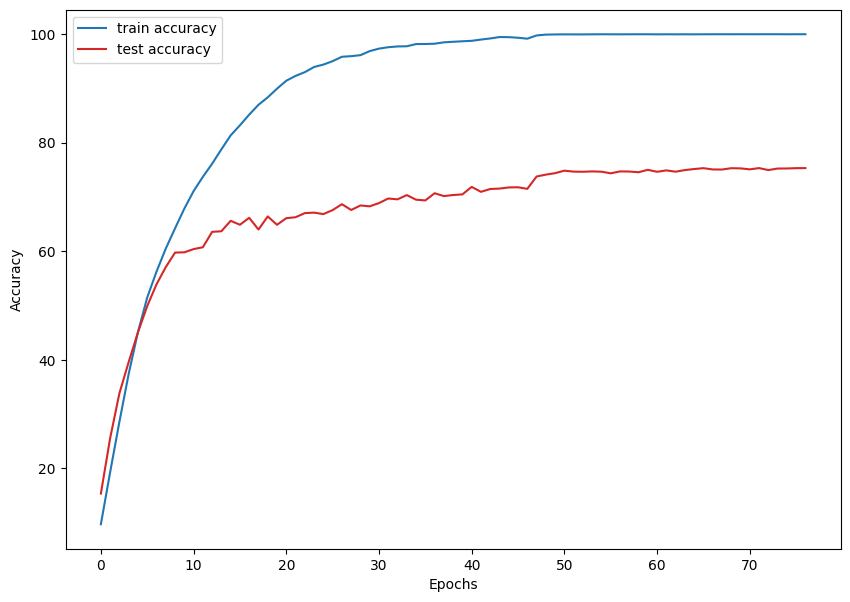

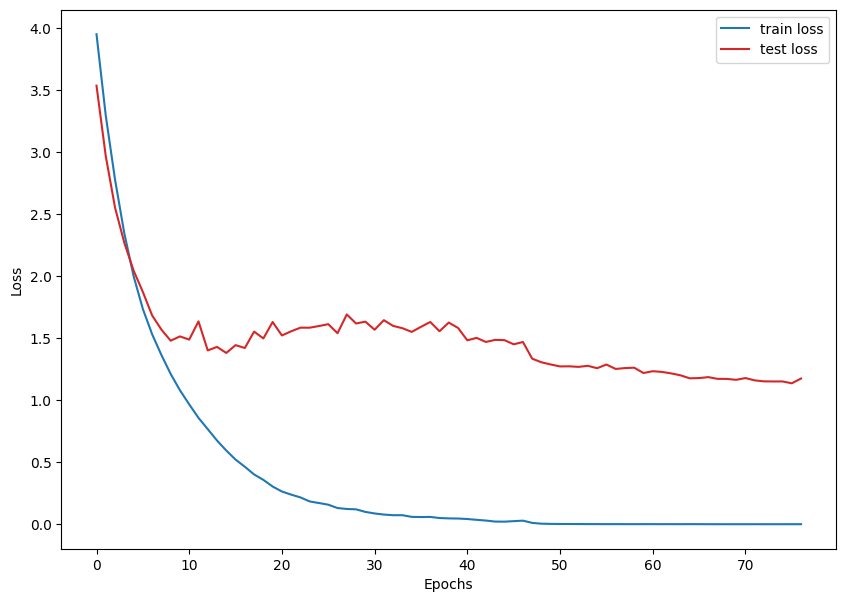

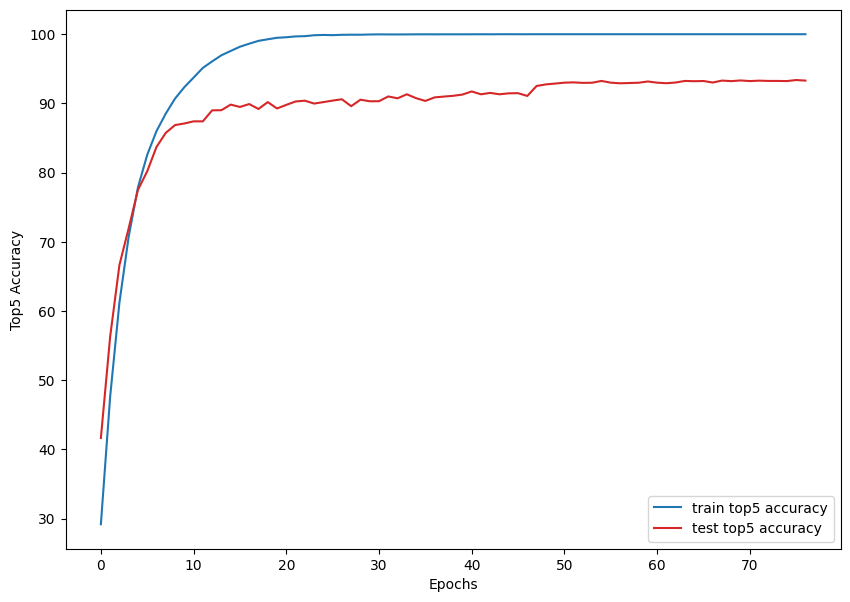

In [28]:
for epoch in range(epochs):
    train_loss,train_acc,train_top5_acc=train(model,trainloader,criterion,optimizer,device)
    print('epoch:{},'.format(epoch))
    test_loss,test_acc,test_top5_acc=test(model,testloader,criterion,device)
    print('train_loss:{:.4f},train_acc:{:.4f},train_top5_acc:{:.4f},test_loss:{:.4f},test_acc:{:.4f},test_top5_acc:{:.4f}'.format(train_loss,train_acc,train_top5_acc,test_loss,test_acc,test_top5_acc))
    torch.save(model.state_dict(), model_name+'.pth')
    train_lossa.append(train_loss)
    test_lossa.append(test_loss)
    train_acca.append(train_acc)
    test_acca.append(test_acc)
    train_top5_acca.append(train_top5_acc)
    test_top5_acca.append(test_top5_acc)

#画图
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)

In [26]:
modelpath='./'
model_last_name='Res2NetFCAepoch=50'
model.load_state_dict(torch.load(modelpath+model_last_name+'.pth'))

<All keys matched successfully>

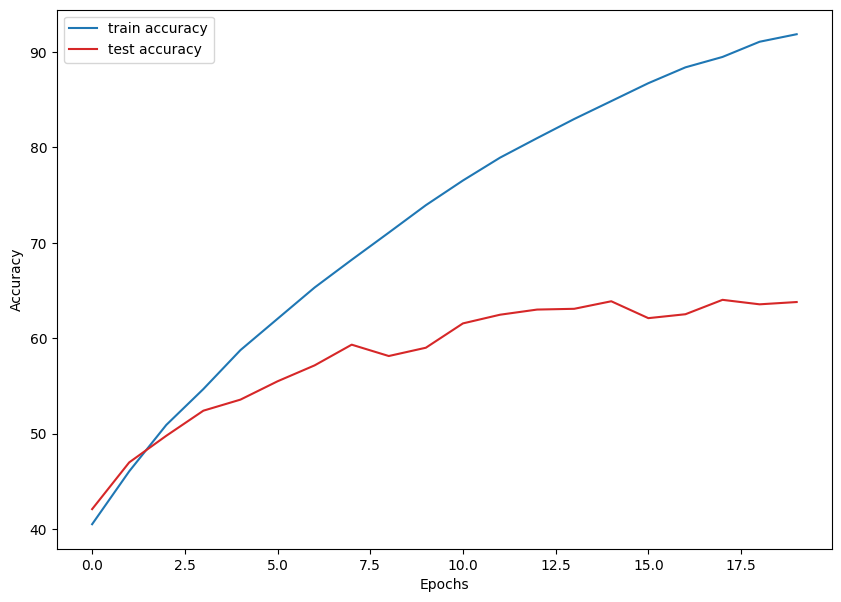

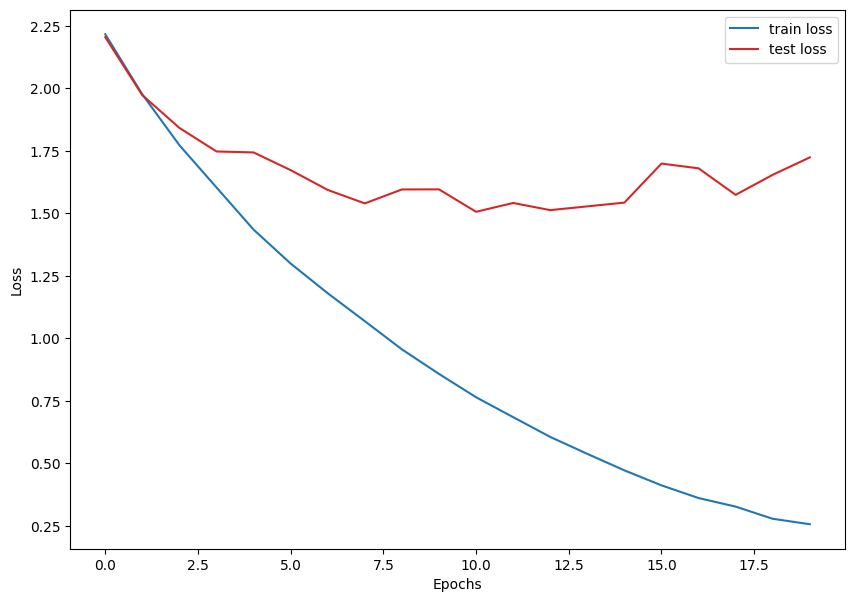

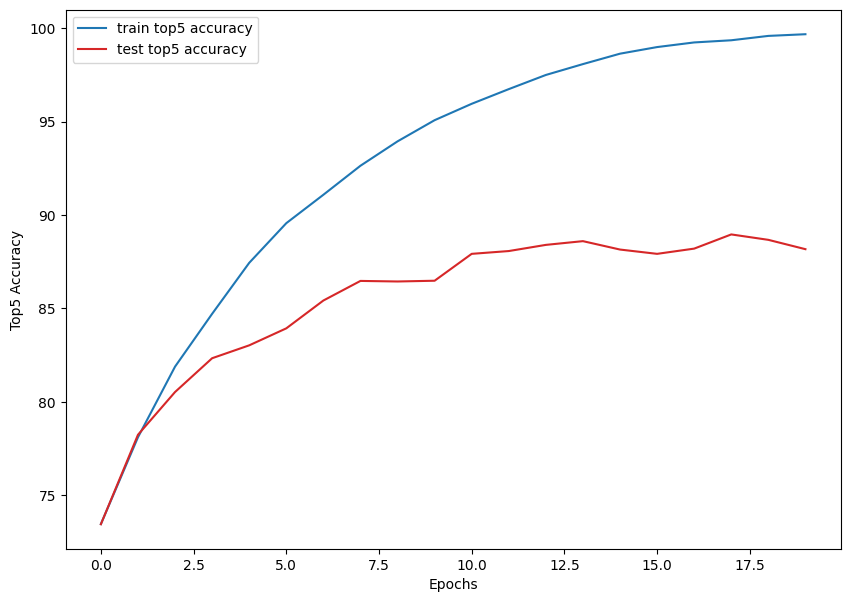

In [17]:
save_plots(train_acca,test_acca,train_lossa,test_lossa,train_top5_acca,test_top5_acca,model_name)